# Real Gas Radiation 2
This notebook is a continuation of the [Real Gas Radiation notebook](https://github.com/jduffield65/ClimateModel/blob/3688bc220a3049466a4cdf279d0ad2fbec3b8a44/Real%20Gas%20Radiation.ipynb).

# Spectra for given temperature profile

As well as evolving an atmosphere towards an equilibrium temperature profile for a given composition and ground temperature, we can also impose a temperature profile and then see what the spectra would look like for different compositions. As we don't have to evolve with time, these plots are much quicker to run and give us more insight into the roles of different molecules. 

## Single spectral line

Let us first look at an artificial molecule which just has one wide spectral line near to the peak of the planetary spectrum:

In [1]:
import warnings
warnings.filterwarnings("ignore") # ignore all warnings in this notebook
import matplotlib.pyplot as plt;
from Model.radiation.base import round_any;
import Model.radiation.real_gas_data.hitran as hitran;
import Model.radiation.real_gas_data.specific_humidity as humidity;
from Model.radiation.real_gas_data.temperature_profiles import earth_temp, fixed_tropopause_temp;
from Model.radiation.real_gas import RealGas, transmission, B_wavenumber, optical_depth;
from Model.radiation.animation import Animate
from IPython.display import HTML;
import numpy as np
p_toa = 0.1  # Top of atmosphere pressure for this notebook (Pa)
n_bands = 200 # number of wavenumber bands in this notebook

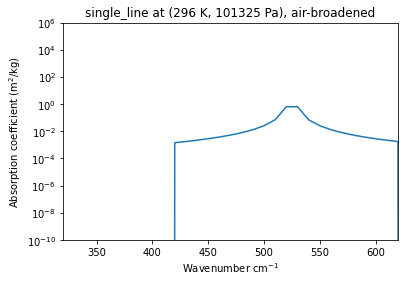

In [2]:
hitran.plot_absorption_coefficient('single_line', hitran.p_reference, 270)

### Inititialise atmosphere
Let us now now initialise an atmosphere that has the temperature profile of the Earth and with this artificial molecule having the same concentration profile of $CO_2$ does for Earth. 

We use 200 wavenumber bands so we can look at the finer detail of the spectra. The outward long wave radiation (OLR) spectrum just shows a single dip where the absorption coefficient is peaked.

In [3]:
single_line_atmos = RealGas(nz='auto', ny=1, molecule_names=['single_line'], p_toa=p_toa,
                            q_funcs={'single_line': humidity.co2}, q_funcs_args={'single_line': (370,)},
                            T_func=earth_temp, n_nu_bands=n_bands)

In [4]:
def plot_T_q_OLR(atmos, log_q=True):
    fig, axs = plt.subplots(1,3, figsize=(18,6))
    axs[0].get_shared_y_axes().join(axs[0], axs[1])
    axs[0].plot(atmos.T, atmos.p)
    axs[0].axes.invert_yaxis()
    axs[0].set_yscale('log')
    axs[0].set_ylabel('Pressure / Pa')
    axs[0].set_xlabel('Temperature / K')
    for molecule_name in atmos.molecule_names:
        if molecule_name == 'single_line':
            M_name = 'CO2'
        else:
            M_name = molecule_name
        axs[1].plot(humidity.ppmv_from_humidity(
                    atmos.q_funcs[molecule_name](atmos.p, *atmos.q_funcs_args[molecule_name]), M_name),
                    atmos.p, label=molecule_name)
    if log_q:
        axs[1].set_xscale('log')
    axs[1].set_xlabel('Volume Mixing Ratio (ppmv)')
    axs[1].legend()
    atmos.plot_olr(ax=axs[2])    

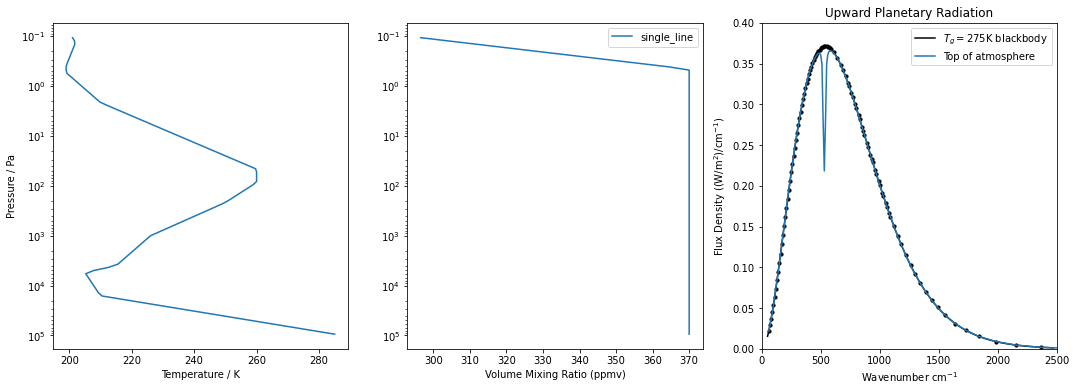

In [5]:
plot_T_q_OLR(single_line_atmos, log_q=False)

### Transmission

The plot below shows the fraction of radiation emitted by the atmosphere at each pressure level that escapes to space in three wavenumber bands. The yellow line covers the peak and the two other bands cover the non-zero fall off either side of it.

The transmission functions are useful for interpretting the OLR spectrum. For instance, in the $530 cm^{-1}$ band, hardly any of the radiation emitted by the surface reaches the top of the atmosphere. Thus the radiation that reaches the top of the atmosphere in this wavenumber range comes from a higher altitude where the temperature is less. Hence the curve in this section is below the surface blackbody curve i.e. it emits with a lower effective temperature.

In [6]:
def get_band(atmos, min_nu, max_nu):
    # combines bands between min_nu and max_nu to form composite band
    d_nu = atmos.nu[1] - atmos.nu[0]
    band = {}
    band['range'] = np.arange(round_any(min_nu, d_nu, 'floor'), round_any(max_nu, d_nu, 'ceil')+d_nu, d_nu)
    band['delta'] = band['range'][-1] - band['range'][0]
    band['centre'] = band['range'][int(len(band['range'])/2)]
    return band

def plot_transmission_setup(ax=None, title=None):
    if ax is None:
        figure, ax = plt.subplots(1,1, figsize = (6, 6))
    ax.set_ylabel('Emitting pressure level / Pa')
    ax.set_xlabel('Transmission')
    if title is not None:
        ax.set_title(title)
    ax.set_yscale('log')
    ax.axes.invert_yaxis()
    return ax
    

def plot_transmission(atmos, band_min_max_list, direction, ax=None, labels='auto', title='auto', init_axes=True):
    # plots transmission function for all bands in band_min_max_list.
    if direction == 'up':
        p1 = atmos.p_interface[:1]
        p2 = atmos.p_interface
        if title == 'auto':
            title = 'Transmission to top of atmosphere'
    elif direction == 'down':
        p1 = atmos.p_interface
        p2 = atmos.p_interface[-1:]
        if title == 'auto':
            title = 'Transmission to surface'
    p_all = atmos.p_interface
    if init_axes:
        ax = plot_transmission_setup(ax, title)
    i=0
    for band_min_max in band_min_max_list:
        band = get_band(atmos, band_min_max[0], band_min_max[1])
        trans = transmission(p1, p2, p_all, band['range'], band['delta'], atmos.nu, atmos.tau_interface)
        if labels=='auto':
            label = str(round(band['centre']))
        else:
            label = labels[i]
        ax.plot(trans.reshape(-1), atmos.p_interface, label=label)
        i += 1
    if labels=='auto':
        ax.legend(title=r"$\nu / cm^{-1}$")

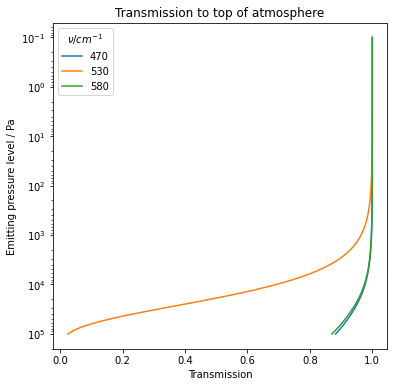

In [7]:
plot_transmission(single_line_atmos, [[420, 520], [520, 530], [530, 620]], 'up')

### Changing Composition

We now investigate how increasing the concentration of the molecule affects the OLR. We do this, by multiplying the concentration of the molecule by a scale factor. We then compute the new fluxes and transmission functions. For each concentration, we plot the transmission functions for a selected set of wavenumber bands and the OLR using the function ```varying_compos_plot```.

In [8]:
def get_q_args_list(atmos, molecule_to_change, scale_factors):
    if scale_factors[0] != 1:
        raise ValueError('Initial composition not 1')
    q_args = atmos.q_funcs_args.copy()
    base_compos = list(q_args.copy()[molecule_to_change])[0]
    other_args = q_args[molecule_to_change][1:]
    q_args = []
    q_labels = []
    for i in range(len(scale_factors)):
        q_args.append(atmos.q_funcs_args.copy())
        q_args[i][molecule_to_change] = (base_compos*scale_factors[i], *other_args)
        if scale_factors[i] > 10000:
            label = "{:.1e}".format(scale_factors[i])
        else:
            label = "{:.0f}".format(scale_factors[i])
        q_labels.append(label)
    return q_args, q_labels


def update_flux(atmos, q_args, T_func):
    atmos.q_funcs_args = q_args
    T_interface = T_func(atmos.p_interface)
    atmos.tau_interface = optical_depth(atmos.p_interface[:, 0], T_interface, atmos.nu,
                                        atmos.molecule_names, atmos.q_funcs, atmos.q_funcs_args)
    atmos.up_flux, atmos.down_flux = atmos.get_flux()
    atmos.net_flux = np.sum(atmos.up_flux * atmos.nu_bands['delta'], axis=1) - \
                        np.sum(atmos.down_flux * atmos.nu_bands['delta'], axis=1)  


def varying_compos_plot(atmos, q_args_list, band_min_max_list, T_func, q_labels_list, direction='up', plot=True):
    """For each composition given by q_args_list, transmission function in wavenumbers given by band_min_max_list,
    and OLR will be plotted"""
    if plot:
        figure, axs = plt.subplots(1,len(band_min_max_list)+1, figsize=(18,6))
        # link transmission axes
        if len(axs)>2:
            axs[0].get_shared_y_axes().join(*axs[:-1])
            axs[0].get_shared_x_axes().join(*axs[:-1])
        axs[0] = plot_transmission_setup(ax=axs[0])
        # get wavenumber bands to plot transmission for
        bands = []
        for i in range(len(band_min_max_list)):
            bands.append(get_band(atmos, band_min_max_list[i][0], band_min_max_list[i][1]))
            axs[i].set_title(r"Transmission for band centered on $\nu = {}$".format(round(bands[i]['centre'])) + " $cm^{-1}$")

    area_under_curve = []
    bands = []
    # get wavenumber bands to plot OLR for (all long wave)
    bands_use = atmos.nu_bands['sw'] == False
    bands_use[np.where(bands_use == False)[0][0]] = True  # add extra band so not cut off before end of axis
    # go through all composition values, calculating OLR at each
    for j in range(len(q_args_list)):
        update_flux(atmos, q_args_list[j], T_func)
        if plot:
            for i in range(len(band_min_max_list)):
                if i==0:
                    q_label = [q_labels_list[j]]
                else:
                    q_label = [None]
                plot_transmission(atmos, [band_min_max_list[i]], direction, axs[i], labels=q_label, title=None, init_axes=False)
            if j==0:
                atmos.plot_olr(olr_label=None, ax=axs[-1], show_bands=False)
            else:
                axs[-1].plot(atmos.nu_bands['centre'][bands_use], atmos.up_flux[0, bands_use])
        area_under_curve.append(np.trapz(atmos.up_flux[0, :], atmos.nu_bands['centre']))
    if plot:
        axs[0].legend(title="Multiple of initial\nconcentration")
    else:
        axs = None
    update_flux(atmos, q_args_list[0], T_func)  # return to initial value
    return axs, area_under_curve

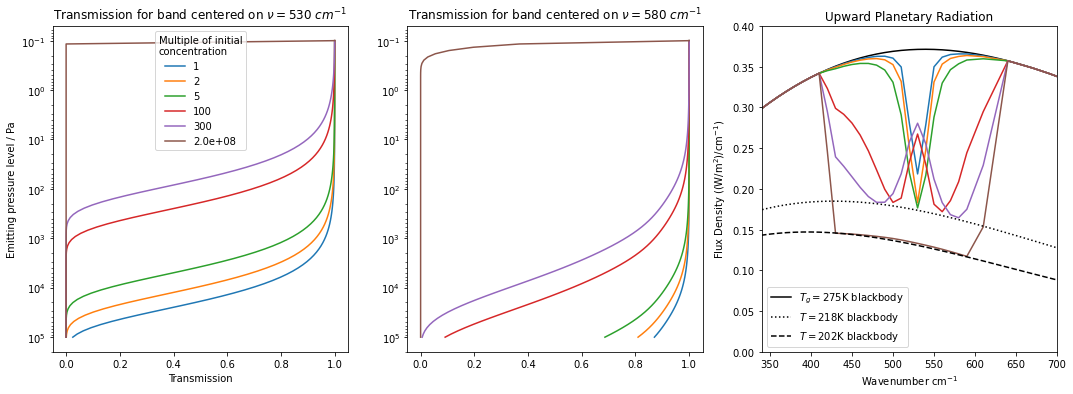

In [9]:
q_args, q_labels = get_q_args_list(single_line_atmos, 'single_line', [1.0, 2.0, 5.0, 100.0, 300.0, 200000000.0])
nu_bands = [[520, 530], [530, 620]]
axs = varying_compos_plot(single_line_atmos, q_args, nu_bands, earth_temp, q_labels)[0]
axs[2].set_xlim((340, 700));   # only cover region where absorption coefficient non zero
axs[2].plot(single_line_atmos.nu_lw, B_wavenumber(single_line_atmos.nu_lw, 218)*np.pi,
            label='$T=218$K blackbody', color='k', linestyle='dotted');
axs[2].plot(single_line_atmos.nu_lw, B_wavenumber(single_line_atmos.nu_lw, 202)*np.pi,
            label='$T=202$K blackbody', color='k', linestyle='dashed');
axs[2].legend();

### Interpretation

By virtue of energy conservation, the area under the OLR curve shown in the third plot must remain constant (must equal to incoming short wave energy from the sun). This gives an explanation for the greenhouse effect, as increasing the concentration clearly increases the size of the chunk taken out of the OLR spectrum. Thus to keep the area under the curve constant, the ground temperature would have to increase, raising the height of the outer envelope (the solid black line). Of course, in this example we assume the temperature profile remains the same as the composition changes which is not the case.

Let's now consider the different concentrations in more detail:

- #### $2\times$: 
As we double the concentration between the blue and yellow curves, the centre of the peak moves downward to a lower emitting temperature. This is because the emitting level is in the troposphere at these concentrations so increasing the concentration raises the altitude of the emitting level and thus reduces the temperature. 

- #### $5\times$: 
Going from the yellow to the green curve, the flux density at the peak centre doesn't change. This is because, looking at the left transmission plot, both these concentrations have no emission to the top of the atmosphere from the surface. The emission is spread across levels between just below the tropopause and just above it. Hence the effective emission temperature is above that of the tropopause ($218 K$ shown by the dotted line as opposed to the tropopause temperature of $205 K$). If the specific humidity profile was such that the drop off in transmission between 1 and 0 occured over a smaller pressure range, then we would expect the effective temperature of this stagnation point to be the tropopause temperature.

    Away from the centre of the peak, we do see that the effective temperature is dropping. So even though we have saturation at the peak centre, increasing the concentration still leads to warming of the surface.
    
- #### $100\times$: 
Going from the green to the red curve, we see that for some wavenumbers, $\nu \approx 500-550 cm^{-1}$, the effective emitting temperature is above the saturation level of $218 K$. This is because the emitting level is now in the stratosphere where temperature is increasing with altitude. At this concentration, the emitting temperature is below the surface temperature over the whole range of the spectral line.

- #### $300\times$:
Going from the red to the purple curve, we see that near the peak centre, the emitting temperature increases (as emitting level in the stratosphere) whereas away from the centre, the emitting level is still in the troposphere so the emitting temperature decreases. As now all wavenumbers in the spectral line are active, the change in the size of the chunk taken out of the spectrum going from $100\times$ to $300\times$ concentration is much greater than the change between $1\times$ and $5\times$. The bigger the chunk, the greater the increase of surface temperature. So if the molecule has spectral lines with large widths, the warming power actually becomes greater once the central peak has become saturated, if the full wavenumber range of the line can become active (i.e. if the continuum of the absorption coefficient is not too far below the peak).

- #### $200000000\times$
At this massive concentration, there is saturation across the whole wavenumber range of the spectral line. So the effective emitting temperature is that of the top of the atmosphere ($202K$ as shown by the dashed curve in the third plot).

### Fixed tropopause temperature

If we repeat this analysis but with a temperature profile that is fixed at the tropopause temperature for altitudes above the tropopause, then the results are a bit more obvious. We see that as the concentration increases, a greater number of wavenumbers become saturated at the tropopause temperature of $205 K$. Once saturation has occured at a particular wavenumber, then the flux remains constant at that wavenumber as concentration changes further (because as the emitting level rises, the emitting temperature remains the same).

In [10]:
single_line_atmos_fixed_trop = RealGas(nz='auto', ny=1, molecule_names=['single_line'], p_toa=p_toa,
                               q_funcs={'single_line': humidity.co2}, q_funcs_args={'single_line': (370,)},
                               T_func=fixed_tropopause_temp, n_nu_bands=n_bands)

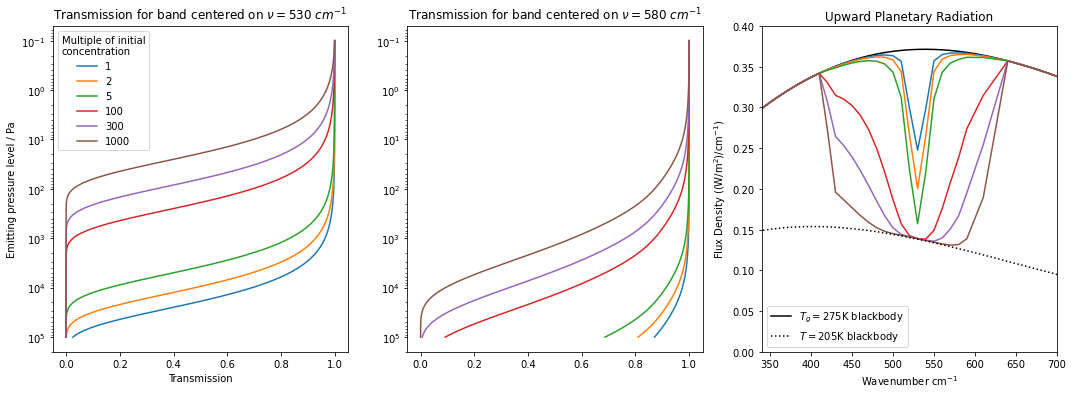

In [11]:
q_args, q_labels = get_q_args_list(single_line_atmos_fixed_trop, 'single_line', [1.0, 2.0, 5.0, 100.0, 300.0, 1000.0])
nu_bands = [[520, 530], [530, 620]]
axs = varying_compos_plot(single_line_atmos_fixed_trop, q_args, nu_bands, fixed_tropopause_temp, q_labels)[0]
axs[2].set_xlim((340, 700));   # only cover region where absorption coefficient non zero
axs[2].plot(single_line_atmos_fixed_trop.nu_lw, B_wavenumber(single_line_atmos_fixed_trop.nu_lw, 205)*np.pi,
            label='$T=205$K blackbody', color='k', linestyle='dotted');
axs[2].legend();

## Earth spectra

Now, lets look at how changing the concentrations of the greenhouse gases affects the OLR of Earth's atmosphere. We first initialise the atmosphere with the earth temperature structure and the earth specific humidities for $CO_2$, $CH_4$, $H_2O$ and $O_3$.

We can see that the main feature is a big dip due to $CO_2$ at about $\nu = 675cm^{-1}$. There is also significant absorption due to $H_2O$ at around $1500cm^{-1}$ and below $500cm^{-1}$.

In [12]:
earth_atmos = RealGas(nz='auto', ny=1, molecule_names=['CO2', 'CH4', 'H2O', 'O3'],
                      p_toa=p_toa, T_func=earth_temp, n_nu_bands=n_bands)

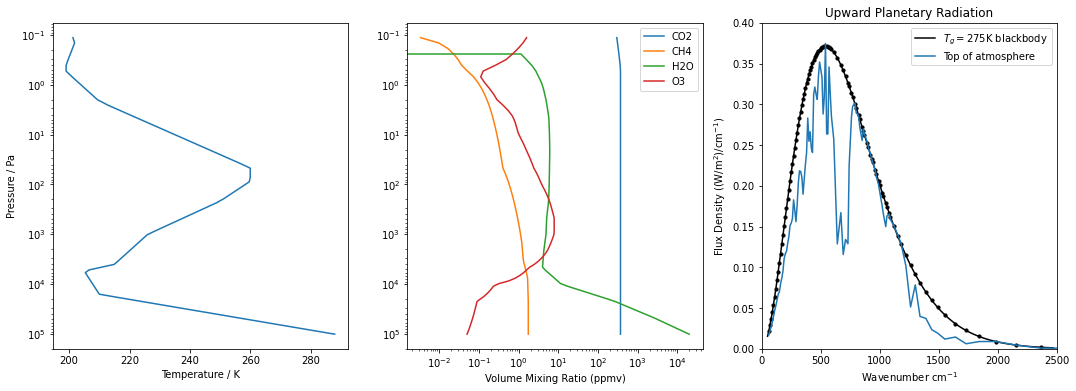

In [13]:
plot_T_q_OLR(earth_atmos, log_q=True)

### $CO_2$

We first look at changing the concentration of $CO_2$. In the cell below, we multiply the initial concentration by 2 and 100. We can see that doubling the concentration has pretty much no effect on the OLR or the transmission function. 

Looking at the green curve, we can see that at current earth levels of $CO_2$, the peak at $\nu = 675cm^{-1}$ has reached saturation, so adding more $CO_2$ raises the effective temperature at this wavenumber, because the emission level is pushed higher into the stratosphere and thus to higher temperatures. This is emphasized by the transmission function plot on the left. Away from the peak though, we see that the outer bands of the spectral line have emitting temperatures in the troposphere so increasing concentrations lowers the emission temperatures here. Again, this is clear from the middle transmission plot.

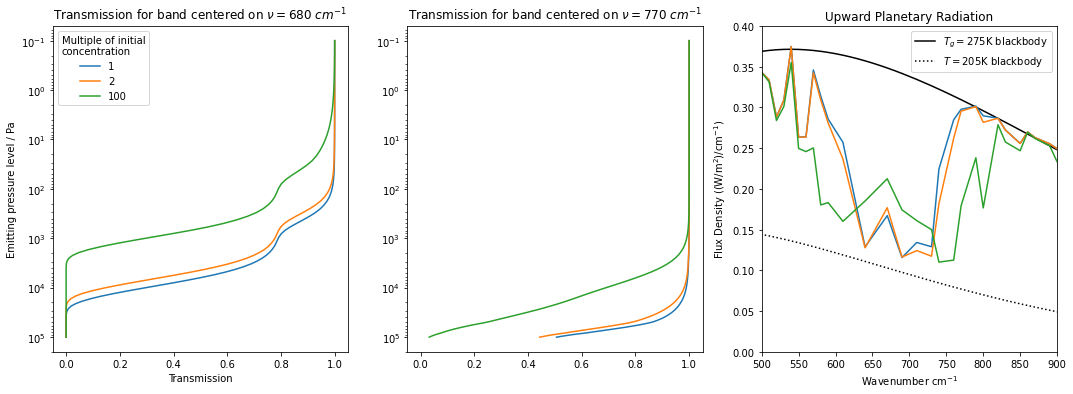

In [14]:
co2_multiplier = np.array([1.0, 2.0, 100.0])
q_args, q_labels = get_q_args_list(earth_atmos, 'CO2', co2_multiplier)
nu_bands = [[650, 700], [740, 800]]
axs = varying_compos_plot(earth_atmos, q_args, nu_bands, earth_temp, q_labels)[0]
axs[2].set_xlim((500,900));
# axs[2].set_xlim((340, 700));   # only cover region where absorption coefficient non zero
axs[2].plot(earth_atmos.nu_lw, B_wavenumber(earth_atmos.nu_lw, 205)*np.pi,
            label='$T=205$K blackbody', color='k', linestyle='dotted');
axs[2].legend();

### $CH_4$

We now compare the effect of $CO_2$ to that of $CH_4$. To aid this comparision, we add the equivalent mass of $CH_4$ to the mass of $CO_2$ added in the above plots. As the starting mass of methane is much less, the amount we multiply the initial concentration of methane by (as indicated by the legend on the left plot) is much greater. We compute these multipliers using the function ```molecule_multiplier_from_co2``` defined in the below cell.



In [15]:
def molecule_multiplier_from_co2(molecule, co2_mult):
    # finds scale factor to initial molecule concentration to give same increase in mass as was applied with a co2 multiplier
    # I.e. if needed for the question we add y kg of molecule instead of y kg of CO2, what is the warming?
    surface_base_ppmv = {'CO2': 370.0, 'CH4': 1.75, 'H2O': 20000, 'O3': 7.9}
    mass_co2_added = (co2_mult * surface_base_ppmv['CO2'] - surface_base_ppmv['CO2']) * humidity.molecules['CO2']['M']
    eqv_ppmv_molecule_added = mass_co2_added / humidity.molecules[molecule]['M']
    molecule_ppmv_total = surface_base_ppmv[molecule] + eqv_ppmv_molecule_added
    molecule_mult = molecule_ppmv_total / surface_base_ppmv[molecule]
    return molecule_mult

def plot_absorption(ax=None, xlim=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(8,6))
    hitran.plot_absorption_coefficient('CO2', hitran.p_reference, 270, ax)
    hitran.plot_absorption_coefficient('CH4', hitran.p_reference, 270, ax)
    hitran.plot_absorption_coefficient('H2O', hitran.p_reference, 270, ax)
    hitran.plot_absorption_coefficient('O3', hitran.p_reference, 270, ax)
    ax.set_title('Absorption Coefficient at 270K, 101320 Pa');
    ax.legend(labels=['CO2', 'CH4', 'H2O', 'O3']);
    if xlim is not None:
        ax.set_xlim(xlim);
        

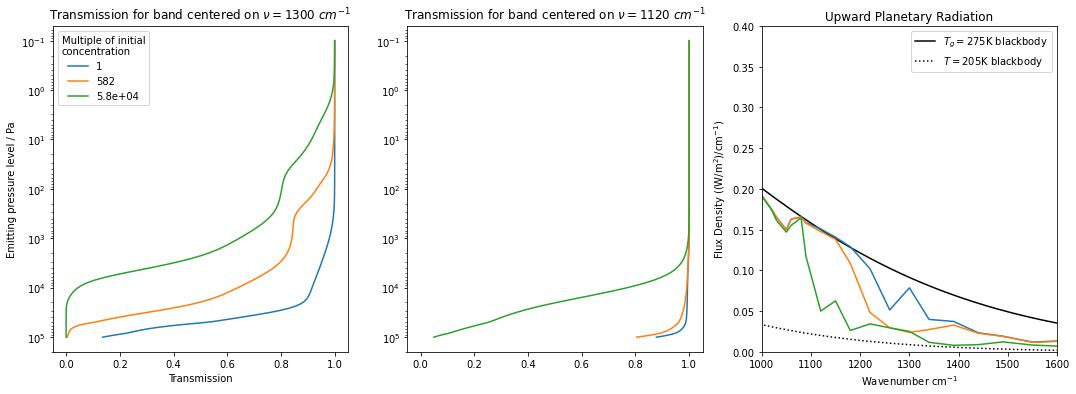

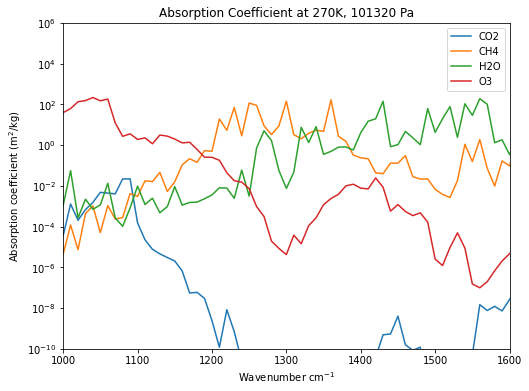

In [16]:
ch4_multiplier = molecule_multiplier_from_co2('CH4', co2_multiplier)
q_args, q_labels = get_q_args_list(earth_atmos, 'CH4', ch4_multiplier)
nu_bands = [[1200, 1400],[1090,1150]]
axs = varying_compos_plot(earth_atmos, q_args, nu_bands, earth_temp, q_labels)[0]
axs[2].set_xlim((1000, 1600));
axs[2].plot(earth_atmos.nu_lw, B_wavenumber(earth_atmos.nu_lw, 205)*np.pi,
            label='$T=205$K blackbody', color='k', linestyle='dotted');
axs[2].legend();
plot_absorption(xlim=(1000, 1600))

From the above plots, we see that the difference between the yellow and blue lines corresponding to a $CO_2$ multiplier of 2 is much greater for methane than $CO_2$. From the absorption coefficient plot, we see that methane is the strongest greenhouse gas between $\nu = 1200 - 1400cm^{-1}$. This is the range used for the left transmission plot. It shows that at current Earth concentrations, the peak of the line is not saturated yet and even after factor of 582 increase, the emitting temperature is still in the troposphere. By the time we reach the green curve though, the emitting temperature is in the stratosphere and starting to increase again. 


### Total Outgoing Flux plot
It is often said that $CH_4$ is a more powerful greenhouse gas than $CO_2$. To investigate this, lets plot the total OLR (integral of above OLR curves over entire wavenumber range) against the mass of the gas added above the initial earth values. This is shown below for each of the four gases (I use the multiple of initial $CO_2$ concentrations as my unit of mass much as with the above methane plots). 

From this, we can clearly see that adding the a given mass of $CH_4$ reduces the OLR by a greater amount than the same mass of $CO_2$ hence it has a greater warming effect as expected. From the above plots, we know this is because initially the most significant methane peak has not reached saturation so adding more methane increases the absorption at the peak. However, the main $CO_2$ peak has already reached saturation so adding more $CO_2$ only affects the bands further away from the peak. So really the reason methane is a strong greenhouse gas is because there is currently little methane in the atmosphere. 

If the starting value of methane corresponded to more than 20 on the x axis of this plot, then it is clear that the effect of adding an equivalent mass of $CO_2$ and $CH_4$ is pretty much the same (the gradient of the blue and orange curves are the same).

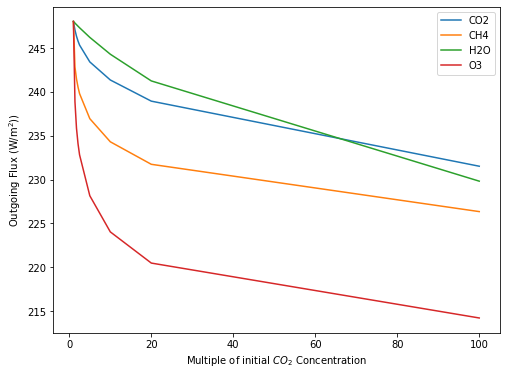

In [17]:
co2_multiplier_area_plot = np.concatenate((np.linspace(1.0, 2.5, 5), np.array([5.0, 10.0, 20.0, 100.0])))
fig, ax = plt.subplots(1,1, figsize=(8,6))
for molecule in ['CO2', 'CH4', 'H2O', 'O3']:
    scale_factor = molecule_multiplier_from_co2(molecule, co2_multiplier_area_plot)
    q_args, q_labels = get_q_args_list(earth_atmos, molecule, scale_factor)
    tot_flux = varying_compos_plot(earth_atmos, q_args, nu_bands, earth_temp, q_labels, plot=False)[1]
    ax.plot(co2_multiplier_area_plot, tot_flux, label=molecule)
ax.legend()
ax.set_ylabel('Outgoing Flux (W/m$^2$))');
ax.set_xlabel('Multiple of initial $CO_2$ Concentration');

### $O_3$

Interestingly, the above plot shows that ozone not methane is the most potent greenhouse gas currently. Obviously this is of less interest because amounts of $CH_4$ are increasing in the atmosphere through anthropogenic activity whereas concentrations of $O_3$ are not (quite the opposite).

Anyway, lets see if we can work out why $O_3$ is so potent. The below plots are analagous to the methane plots above (yellow curve corresponds to an increase in $O_3$ mass equivalent to doubling $CO_2$ concentration and the green curve corresponds to $100\times$ the $CO_2$ concentration).

From the absorption coefficient plot below, we see that $O_3$ is the most potent greenhouse gas in the wavenumber range $\nu \approx 750-850 cm^{-1}$. This is the range used to make the transmission plot on the left. From this transmission plot and the OLR plot we see that in this wavenumber range, at current ozone levels, there is basically no absorption of radiation and all the radiation from the surface escapes to space. Hence any ozone that is added basically has free range to capture photons of this wavenumber and is not competing with any other molecules. Thus we see a huge chunk taken out of the spectrum here between the blue and green curves.

From the absorption plot, we see that ozone is actually strongest in the range $\nu \approx 650-750 cm^{-1}$. However, in this range $CO_2$ is even more potent and at the initial concentrations, the emitting levels are near the tropopause in this range as shown by the second transmission plot (and in the stratosphere over part of it as shown by the upwards spike at about $680 cm^{-1}$ in the flux plot). By the time we reached the green curve, the emitting temperature is in the stratosphere over this entire wavenumber range as shown in the second plot.

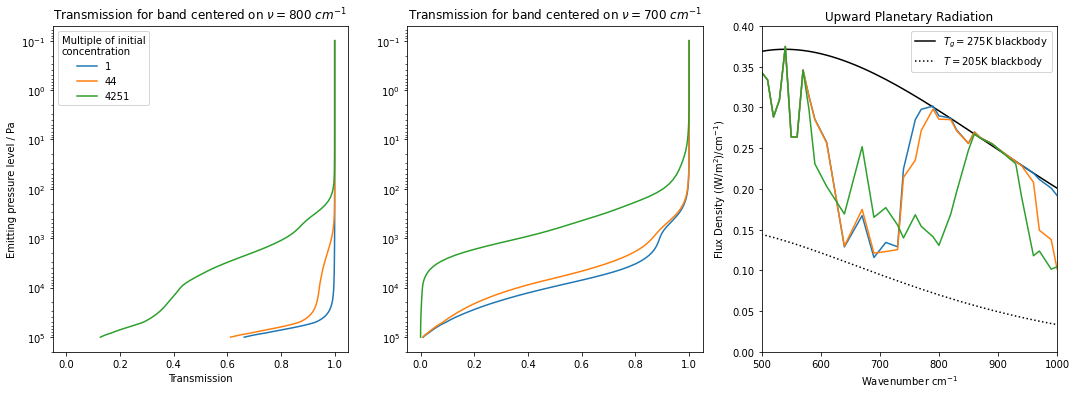

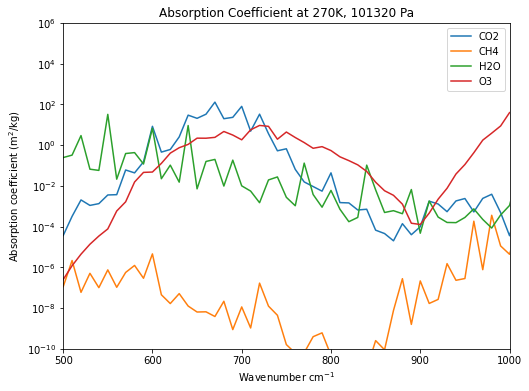

In [18]:
o3_multiplier = molecule_multiplier_from_co2('O3', co2_multiplier)
q_args, q_labels = get_q_args_list(earth_atmos, 'O3', o3_multiplier)
nu_bands = [[750, 850], [650,750]]
axs = varying_compos_plot(earth_atmos, q_args, nu_bands, earth_temp, q_labels)[0]
axs[2].set_xlim((500, 1000));
axs[2].plot(earth_atmos.nu_lw, B_wavenumber(earth_atmos.nu_lw, 205)*np.pi,
            label='$T=205$K blackbody', color='k', linestyle='dotted');
axs[2].legend();
plot_absorption(xlim=(500,1000));